# Solow Model with finite resources and climate externalities

Imports and set magics:

In [11]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
#XD FOR SMART UPLOAD
# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description



We consider a Solow-model that incorporates fossil fuels and climate externalities 

 The model structure is 

1 $$Y_t=D_tK^\alpha _t(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

2 $$ K_{t+1}=sY_t+(1-\delta) K_t, \text{  } 0<\delta<1 $$

3 $$L_{t+1}=(1+n)L_t, \text{   } n\geq 0$$

4 $$A_{t+1}=(1+g)A_t, \text{   } g\geq 0$$

5 $$ R_{t+1}=R_t-E_t$$

6 $$ E_t=s_ER_t, \text{   } 0<s_E<\delta $$

7 $$ D_t=\left(\frac{R_t}{R_0}\right)^{\phi},\text{   }\phi\geq 0$$






* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $E_t$ is "Oil" (where the amount used in each period is a fraction of the remaining reserve)
* $R_t$ is the remaining reserve of oil, $R_0$ is the initial reserve 
* $A_t$ is technology (growing with a constant rate of $g$)
* $D_t$ is the damage function
* $Y_t$ is GDP





Using the above equations, the following transition curve can be found 

$$z_{t+1} =\left(\frac{1}{1-s_E}\right)^{\varepsilon+\phi}\left(\frac{1}{(1+n)(1+g)}\right)^\beta (s+(1-\delta)z_t)^{1-\alpha})z_t^\alpha$$

where $z_t$ is the capital/output ratio $z_t=\frac{K}{Y}$
 

## Specification of the damage function

In our model specification, the damage function directly affects the production Y. This means the direct interperetation of the damage function is that expending fossile fuels, R, destroys output. Other ways to model this could be that the damage function is applied to Capital or maybe add landmass to the model and have the damage function diminish the landmass. These alternative specifications can give the damage function a better interperetation. In the example of reducing landmass, the interperetation would be that expenditure of fossile fuels causes landmass to be reduced via global warming which melts ice that causes the sea level to rise. However, where we apply the damage function is irrelevant, as they are mathematically equivalent if you scale $\phi$

Say for example, the damage function affected Capital instead of directly diminishing output, our model would look like:

$$Y_t=(K_tD_t)^\alpha(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

$\leftrightarrow$

$$Y_t= D_t^\alpha K_t^\alpha(A_tL_t)^{\beta}E^{\epsilon}_t,\text{   }\alpha, \beta, \varepsilon \geq0, \alpha+\beta+\varepsilon=1$$

Which means, that if we scale $\phi$ by $\frac{1}{\alpha}$, these would be completly equivalent. Which is why we don't think it's a problem to have $D_t$ directly affect $Y_t$, despite the implication that usage of fossile fuels directly destroys output. The damage function can essentially be seen as a part of the TFP.

## Solving the model - steady state

In [12]:
# First we consider the Solow model without climate externalities, that is we reduce the model to a Solow model extended with oil only, which is equal to setting phi to zero
# Parameters: 
epsilon = 0.1
beta = 0.6
alpha = 0.3
phi = 0 
delta =0.05
n = 0.01
g = 0.02
s =0.20
se = 0.005

In [13]:
# The condition for steady state, that is z(t) = z(t+1), is rewritten to give the following
obj_zss = lambda z: z- (1/(1-se))**(epsilon+phi)*((1/((1+n)*(1+g)))**beta)*((s+(1-delta)*z)**(1-alpha))*z**alpha

In [14]:
# Now we optimize using the "brentq" method 
Interval = [0.1,100]# An interval in which we expect to find the steady state, defined in a way so that we aviod the trivial steady state 

result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
print(f'The steady state for z is: z* = {result.root:.8f}')

The steady state for z is: z* = 2.66325074


In [15]:
# Now we introduce climate change in the form of the damage function, but allowing phi to take on various values 
phis=[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]


SS_list =[]
for phi in phis: # Obtaining various SS values for z by changing phi 
    result = optimize.root_scalar(obj_zss,bracket=Interval,method="brentq")
    SS_list.append(result.root)

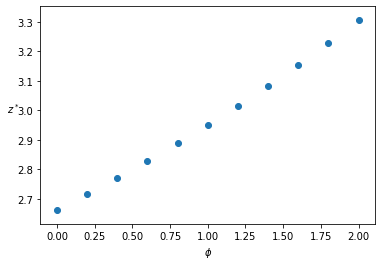

In [16]:
#Plotting relationship between steady state and phi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cs = plt.scatter(phis,SS_list)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$z^*$').set_rotation(0);

## Simulation

We create functions of the model equations we introduced earlier:

In [17]:
def Y_t(D,K,A,L,E,a,b,e):
    return D*(K**a)*((A*L)**b)*(E**e)
def D_t(R,R_0,phi):
    return (R/R_0)**phi
def A_t1(A,g):
    return A*(1+g)
def L_t1(L,n):
    return L*(1+n)
def K_t1(s,Y,d,K):
    return s*Y+(1-d)*K
def R_t1(R,E):
    return R-E
def E_t(sE,R):
    return sE*R    

Then we create a function to simulate the model

In [18]:
def simulate(K0,A0,L0,R0,periods,a=0.3,b=0.6,e=0.1,g=0.02,n=0.01,s=0.2,phi=1,sE=0.005,d=0.05):
    """Simulates the Solowmodel for given starting values of capital, labour, technology and fossil fuels aswell as given model parameters""" 

# First we generate lists to store the output for each endogenus variabel and add/calculate the period 0 values:

    listA = [A0]
    listK = [K0]
    listL = [L0]
    listR = [R0]
    listD = [1]   # The damage function will always be 1 in period 0, since R_t=R_0 -> (R_t/R_0)^phi=1
    listE = [E_t(sE = sE, R = R0)]
    listY = [Y_t(listD[-1], K0, A0, L0, listE[-1], a = a, b = b, e = e)]
    listt = [0] # We always start in period t=0, so the first element in t is 0

    # Now we simulate for the amount of periods specified:
    i = 1 # Where i indicates the period, so we start by simulating periode t=0+1=1
    # The following calculations are done in order of causality, so we can call the last element in the needed variable list, therefore Y has to be done last, so the last element in K, A, L and so on has already been updated for the current period.
    while i <= periods:
        listA.append(A_t1(listA[-1],g = g))
        listK.append(K_t1(Y = listY[-1], K = listK[-1], s = s, d = d))
        listL.append(L_t1(listL[-1], n = n))
        listR.append(R_t1(listR[-1], E = listE[-1]))
        listE.append(E_t(R = listR[-1], sE = sE))
        listD.append(D_t(R = listR[-1], R_0 = R0, phi = phi))
        listY.append(Y_t(D = listD[-1],K = listK[-1],A = listA[-1],L = listL[-1],E = listE[-1], a = a, b = b, e = e))
        listt.append(i)
        i+=1
    
# We return the lists for Y, L, K, t and D as they are the variables we are interested in analyzing.
    return listY, listL, listK, listt, listD, listR

In [19]:
# We define a list of phi values we want to analyze
philist = [0, 0.5, 1, 2]

# Then we simulate a list containing 4 lists of the Y, K and D values for each phi value in philist. The [0] and [2] are because the simulate-function returns 6 lists with Y being index 0 and K beign index 2 etc.
ylist = np.array([simulate(1,1,1,1, 2000, phi = phi)[0] for phi in philist]) 
klist = np.array([simulate(1,1,1,1, 2000, phi = phi)[2] for phi in philist])
dlist = np.array([simulate(1,1,1,1, 2000, phi = phi)[4] for phi in philist])
llist = simulate(1,1,1,1,2000)[1]
tlist = simulate(1,1,1,1,2000)[3]
rlist = simulate(1,1,1,1,2000)[5]
lowercaseylist = np.divide(ylist,llist)
lowercaseylist = np.divide(klist,llist)
# Then we calculate the capital-income-ratio, z, by dividing K with Y
zlist = np.divide(klist,ylist)

In [20]:
smalltlist = simulate(1,1,1,1,200)[3]
smalllist = simulate(1,1,1,1,200)[1]
smallklist = np.array([simulate(1,1,1,1, 200, phi = phi)[2] for phi in philist])
smallylist = np.array([simulate(1,1,1,1, 200, phi = phi)[0] for phi in philist])
smalllowercaseylist = np.divide(smallylist,smalllist)
smalllowercaseklist = np.divide(smallklist,smalllist)
smallzlist = np.divide(smalllowercaseklist,smalllowercaseylist)

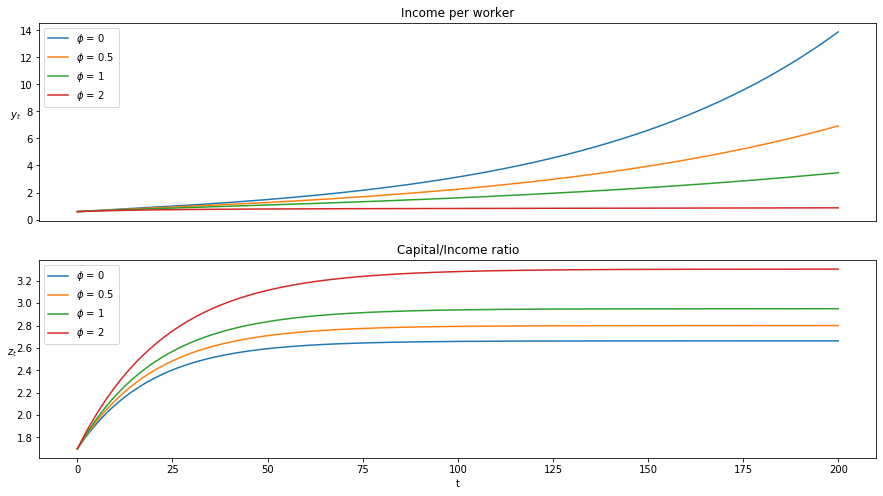

In [21]:
lilyfig = plt.figure(figsize = [15, 8])
ox1 = lilyfig.add_subplot(2,1,1)

plt.plot(smalltlist,smalllowercaseylist[0], label = "$\phi$ = 0")
plt.plot(smalltlist,smalllowercaseylist[1], label = "$\phi$ = 0.5")
plt.plot(smalltlist,smalllowercaseylist[2], label = "$\phi$ = 1")
plt.plot(smalltlist,smalllowercaseylist[3], label = "$\phi$ = 2")
plt.legend()

h = plt.ylabel("$y_t$")
h.set_rotation(0)
plt.xlabel("t")
ox1.set_title("Income per worker")

ox2 = lilyfig.add_subplot(2,1,2)
plt.plot(smalltlist,smallzlist[0], label = "$\phi$ = 0")
plt.plot(smalltlist,smallzlist[1], label = "$\phi$ = 0.5")
plt.plot(smalltlist,smallzlist[2], label = "$\phi$ = 1")
plt.plot(smalltlist,smallzlist[3], label = "$\phi$ = 2")
plt.legend()



ox1.axes.get_xaxis().set_visible(False)
h = plt.ylabel("$z_t$")
h.set_rotation(0)
plt.xlabel("t")
ox2.set_title("Capital/Income ratio");


## What is a realistic value of $\phi$?

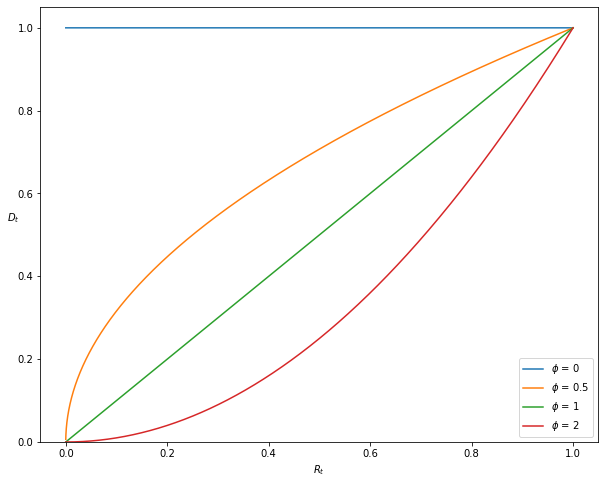

In [27]:
# We create the figure object
damagefig = plt.figure(figsize = [10, 8])
ax = fig.add_subplot(1,1,1)
# Then we add the dataseries
plt.plot(rlist, dlist[0], label = "$\phi$ = 0")
plt.plot(rlist, dlist[1], label = "$\phi$ = 0.5")
plt.plot(rlist, dlist[2], label = "$\phi$ = 1")
plt.plot(rlist, dlist[3], label = "$\phi$ = 2")
plt.legend()
h = plt.ylabel("$D_t$")
h.set_rotation(0)
plt.xlabel("$R_t$")
# We define the lower limit of the y-axis
plt.ylim(bottom = 0);

# Growth Rates 

In [28]:
#Average growth rates in the first 100 periods 
arrayy=np.array(smalllowercaseylist)

for i in range(0,4,1):
    growth_factor = (arrayy[i][99]/arrayy[i][0])
    average_growth = (growth_factor**(1/100)-1)*100
    print(f'The average growth rate in the first 100 periods is: {average_growth:.3f}, for phi = {philist[i]}')



The average growth rate in the first 100 periods is: 1.675, for phi = 0
The average growth rate in the first 100 periods is: 1.336, for phi = 0.5
The average growth rate in the first 100 periods is: 1.000, for phi = 1
The average growth rate in the first 100 periods is: 0.334, for phi = 2


In [29]:
#Growth rates in Steady State
ss_arrayy = np.array(lowercaseylist)
for i in range(0,4,1):
    ss_growth_factor = (ss_arrayy[i][-1]/ss_arrayy[i][149])
    ss_average_growth = (ss_growth_factor**(1/1850)-1)*100
    print(f'The steady state growth rate for phi = {philist[i]} is: {ss_average_growth:.3f}')



The steady state growth rate for phi = 0 is: 1.495
The steady state growth rate for phi = 0.5 is: 1.133
The steady state growth rate for phi = 1 is: 0.771
The steady state growth rate for phi = 2 is: 0.052




# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.